# Model Performance

In [61]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 7)

In [62]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
AFTER_ERA = 310

nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [63]:
# get model ranking
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance
def get_model_performance(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_submissions_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance aggregated
def get_model_performance_aggregated(score, by):
    df = pd.pivot_table(
        data=perf.groupby(["modelName", by])[score].mean().reset_index(),
        values=score,
        index=[by],
        columns=["modelName"]
    )
    return df

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [64]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

14.70646858215332

In [65]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado', 'dh_gaia', 'dh_terra'])

---
# Model Ranks

In [66]:
# get model rankings
rank = get_model_rankings(model_list=model_list)
rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 61
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype                  
---  ------     --------------  -----                  
 0   corrRank   1092 non-null   int64                  
 1   corrRep    1092 non-null   float64                
 2   date       1092 non-null   datetime64[ns, tzutc()]
 3   fncRank    1092 non-null   int64                  
 4   fncRep     1092 non-null   float64                
 5   fncV3Rank  800 non-null    float64                
 6   fncV3Rep   800 non-null    float64                
 7   mmcRank    1092 non-null   int64                  
 8   mmcRep     1092 non-null   float64                
 9   tcRank     885 non-null    float64                
 10  tcRep      885 non-null    float64                
 11  modelName  1092 non-null   object                 
dtypes: datetime64[ns, tzutc()](1), float64(7), int64(3), object(1)
memory usage: 110.9+ KB


In [67]:
# check model name list
rank["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_desperado', 'dh_gaia', 'dh_terra'], dtype=object)

In [68]:
# cols
tc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# Correlation Ranking & Reputation

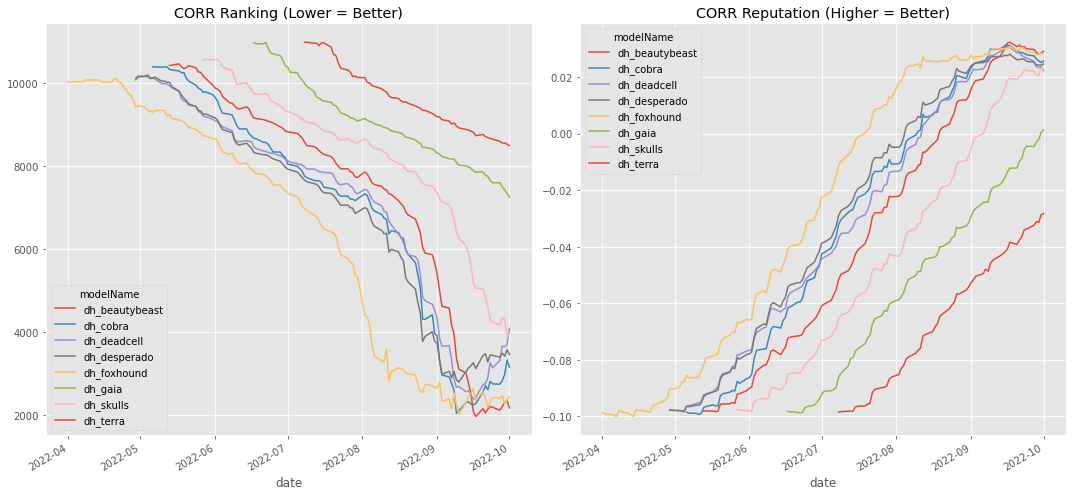

In [69]:
# plot  corr rank and rep
corrdf = rank.loc[rank["date"]>=AFTER_DATE]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

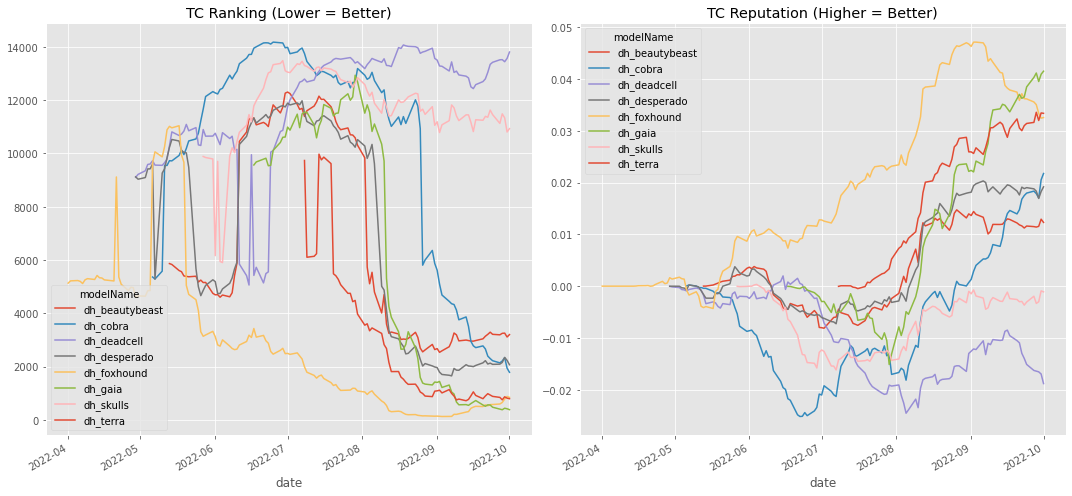

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("TC Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("TC Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/TCRankPlots.png', facecolor='w')
plt.show()

---
# Model Performance by Round

In [71]:
# get round performance
perf = get_model_performance(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5310 entries, 0 to 386
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype                  
---  ------                    --------------  -----                  
 0   corrPercentile            5270 non-null   float64                
 1   correlation               5310 non-null   float64                
 2   correlationWithMetamodel  5270 non-null   float64                
 3   date                      5310 non-null   datetime64[ns, tzutc()]
 4   fnc                       3524 non-null   float64                
 5   fncPercentile             3524 non-null   float64                
 6   mmc                       5270 non-null   float64                
 7   mmcPercentile             5270 non-null   float64                
 8   roundNumber               5310 non-null   int64                  
 9   tc                        4707 non-null   float64                
 10  tcPercentile              4707 non-nu

In [72]:
# performance table
perf.head()

,corrPercentile,correlation,correlationWithMetamodel,date,fnc,fncPercentile,mmc,mmcPercentile,roundNumber,tc,tcPercentile,modelName
0,NaN,0.012502,NaN,2021-06-17 00:00:00+00:00,NaN,NaN,NaN,NaN,256,-0.074116,0.207349,dh_foxhound
1,0.332453,0.054300,0.658724,2021-04-21 00:00:00+00:00,-0.000404,0.127074,-0.003081,0.354575,256,0.007781,0.588808,dh_foxhound
2,0.368150,0.070134,0.658724,2021-04-20 00:00:00+00:00,0.007896,0.154223,-0.001173,0.415661,256,NaN,NaN,dh_foxhound
3,0.425968,0.073977,0.658724,2021-04-17 00:00:00+00:00,0.002263,0.133107,0.002041,0.504399,256,NaN,NaN,dh_foxhound
4,0.360608,0.064221,0.658724,2021-04-16 00:00:00+00:00,0.004787,0.149698,-0.002508,0.333710,256,NaN,NaN,dh_foxhound


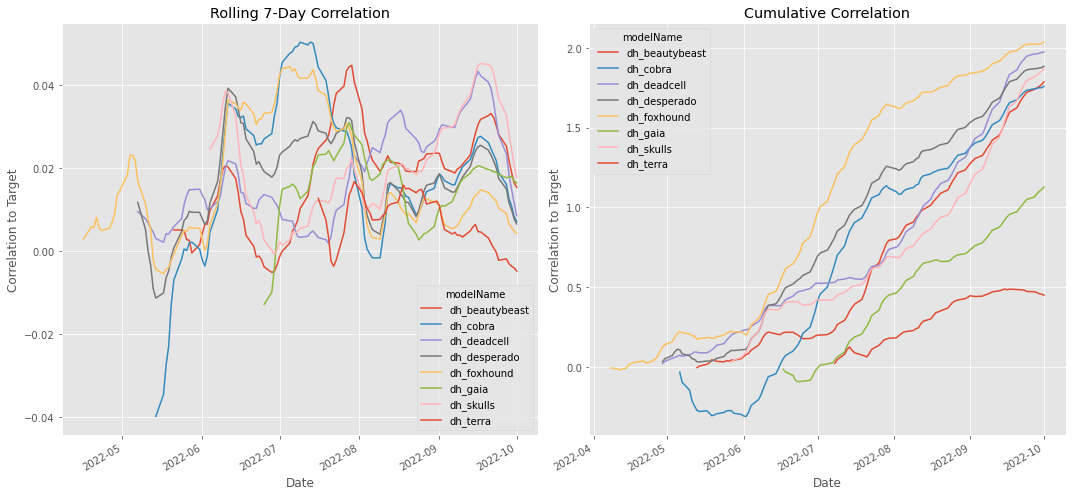

In [73]:
# get mean corr by round
avg_corr_by_era = get_model_performance_aggregated(score="correlation", by="roundNumber")
avg_corr_by_date = get_model_performance_aggregated(score="correlation", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_corr_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_corr_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day Correlation")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation to Target")
axes[1].set_title("Cumulative Correlation")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation to Target")
plt.tight_layout()
plt.savefig('plots/ModelCorrPlots.png', facecolor='w')
plt.show()

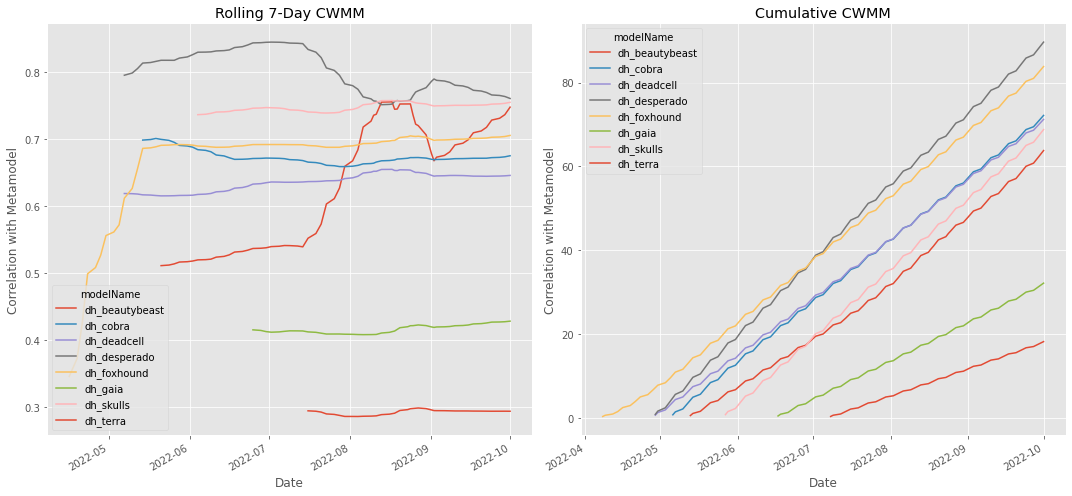

In [74]:
# get mean cwmm by round
avg_cwmm_by_era = get_model_performance_aggregated(score="correlationWithMetamodel", by="roundNumber")
avg_cwmm_by_date = get_model_performance_aggregated(score="correlationWithMetamodel", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_cwmm_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_cwmm_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day CWMM")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation with Metamodel")
axes[1].set_title("Cumulative CWMM")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation with Metamodel")
plt.tight_layout()
plt.savefig('plots/ModelCWMMPlots.png', facecolor='w')
plt.show()

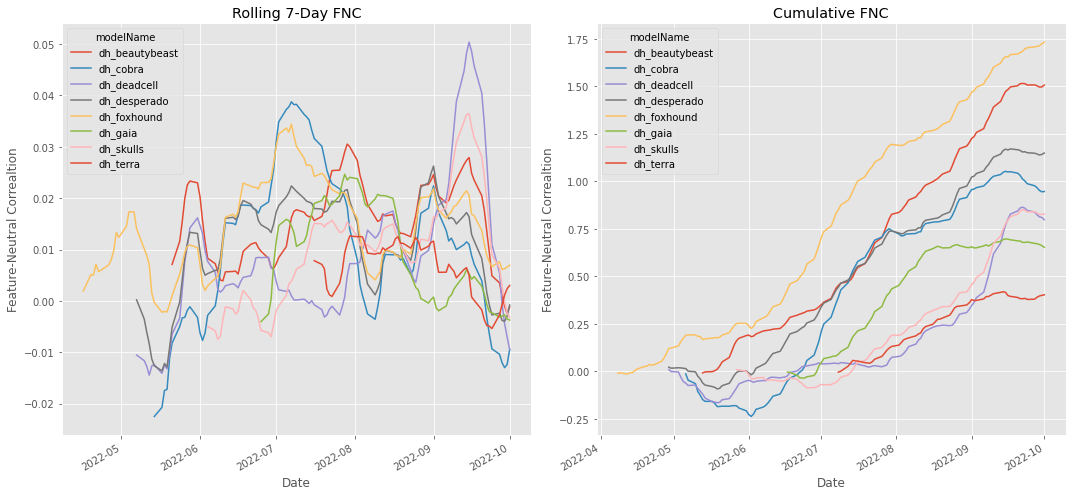

In [75]:
# get mean fnc by round
avg_fnc_by_era = get_model_performance_aggregated(score="fnc", by="roundNumber")
avg_fnc_by_date = get_model_performance_aggregated(score="fnc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_fnc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_fnc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day FNC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Feature-Neutral Correaltion")
axes[1].set_title("Cumulative FNC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Feature-Neutral Correaltion")
plt.tight_layout()
plt.savefig('plots/ModelFNCPlots.png', facecolor='w')
plt.show()

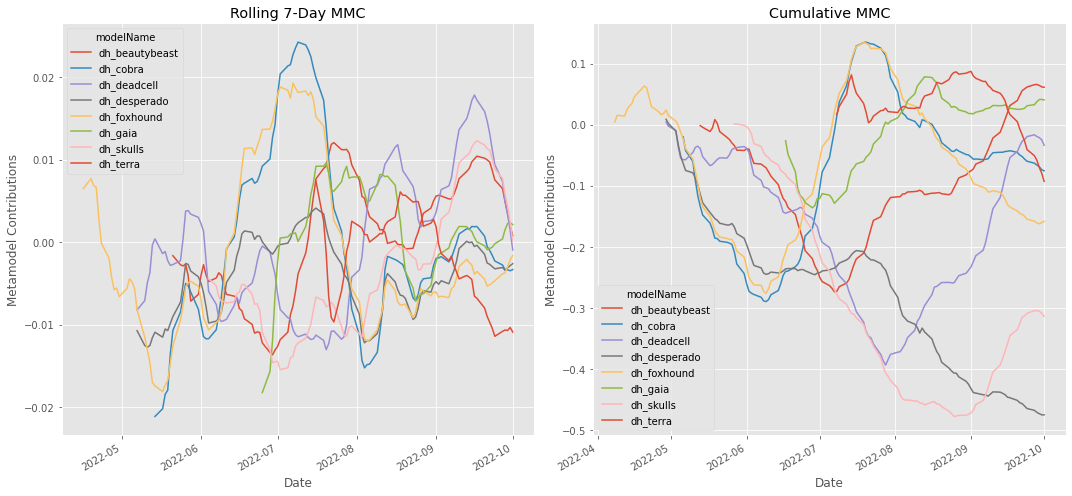

In [76]:
# get mean mmc by round
avg_mmc_by_era = get_model_performance_aggregated(score="mmc", by="roundNumber")
avg_mmc_by_date = get_model_performance_aggregated(score="mmc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_mmc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_mmc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day MMC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Metamodel Contributions")
axes[1].set_title("Cumulative MMC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Metamodel Contributions")
plt.tight_layout()
plt.savefig('plots/ModelMMCPlots.png', facecolor='w')
plt.show()

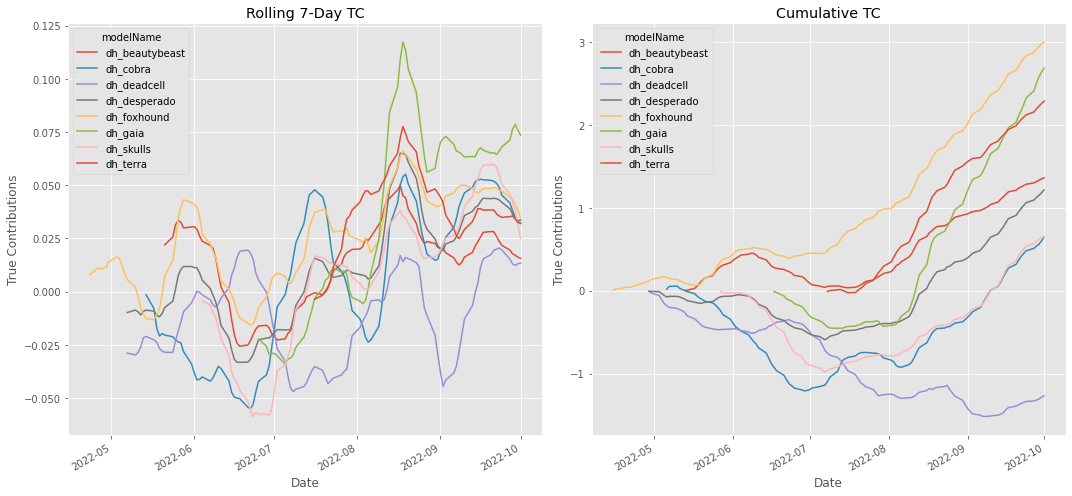

In [77]:
# get mean mmc by round
avg_tc_by_era = get_model_performance_aggregated(score="tc", by="roundNumber")
avg_tc_by_date = get_model_performance_aggregated(score="tc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_tc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_tc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day TC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("True Contributions")
axes[1].set_title("Cumulative TC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("True Contributions")
plt.tight_layout()
plt.savefig('plots/ModelTCPlots.png', facecolor='w')
plt.show()

---
# Model Payouts & Staking

In [78]:
# get payout
payout = get_model_value(model_list, "payout")
payout.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_gaia,dh_skulls,dh_terra,totalValue
roundResolveTime,,,,,,,,,
2022-09-01 20:00:00+00:00,0.010448,0.112149,0.012897,0.103759,0.085457,-0.000237,0.010530,0.000000,0.335003
2022-09-08 20:00:00+00:00,0.018489,0.212781,0.020959,0.197904,0.151193,0.003347,0.021466,0.000000,0.626139
2022-09-15 20:00:00+00:00,0.031320,0.318475,0.026037,0.283953,0.239007,0.003149,0.029908,0.076116,1.007964
2022-09-22 20:00:00+00:00,0.009783,0.055342,0.015348,0.094105,0.147751,0.005466,0.018455,0.006031,0.352280
2022-09-29 20:00:00+00:00,0.002661,0.046114,0.000386,0.112014,0.185078,0.006893,0.002404,0.004231,0.359781


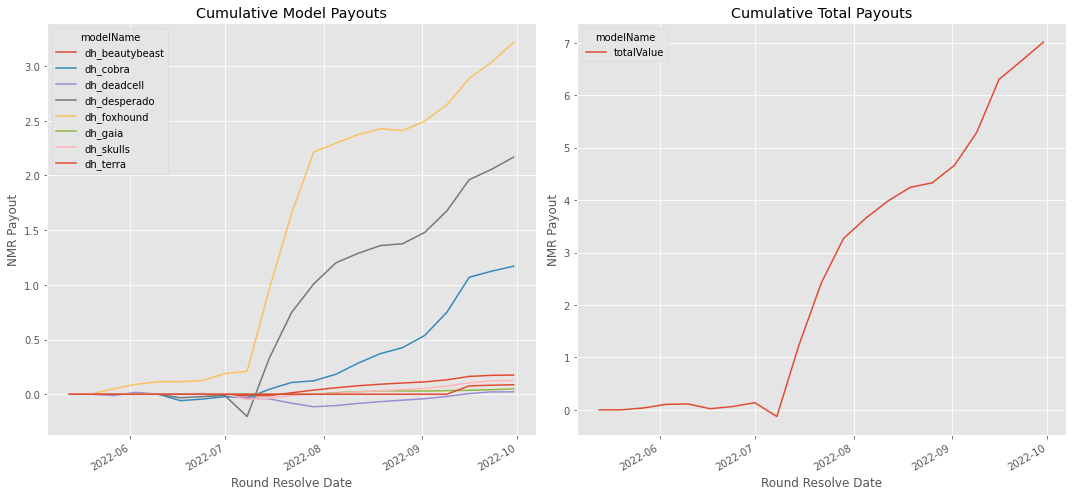

In [79]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2)
payout.loc[AFTER_DATE:][[col for col in payout.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
payout.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Payouts")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Payout")
axes[1].set_title("Cumulative Total Payouts")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Payout")
plt.tight_layout()
plt.savefig('plots/PayoutPlots.png', facecolor='w')
plt.show()

In [80]:
# get payout
staking = get_model_value(model_list, "staking")
staking.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_gaia,dh_skulls,dh_terra,totalValue
roundResolveTime,,,,,,,,,
2022-09-01 20:00:00+00:00,1.037553,16.122440,0.885181,16.008340,17.214776,1.000000,0.999847,0.0,53.268137
2022-09-08 20:00:00+00:00,1.058732,16.182505,0.895739,16.201154,17.294451,1.013949,1.008475,0.0,53.655004
2022-09-15 20:00:00+00:00,1.077222,16.284148,0.915887,16.287764,17.373047,1.022683,1.022175,1.0,54.982928
2022-09-22 20:00:00+00:00,1.091321,16.370960,0.932113,16.358517,17.425907,1.031215,1.032942,1.0,55.242975
2022-09-29 20:00:00+00:00,1.102352,16.425419,0.945776,16.375313,17.409936,1.029717,1.042172,1.0,55.330686


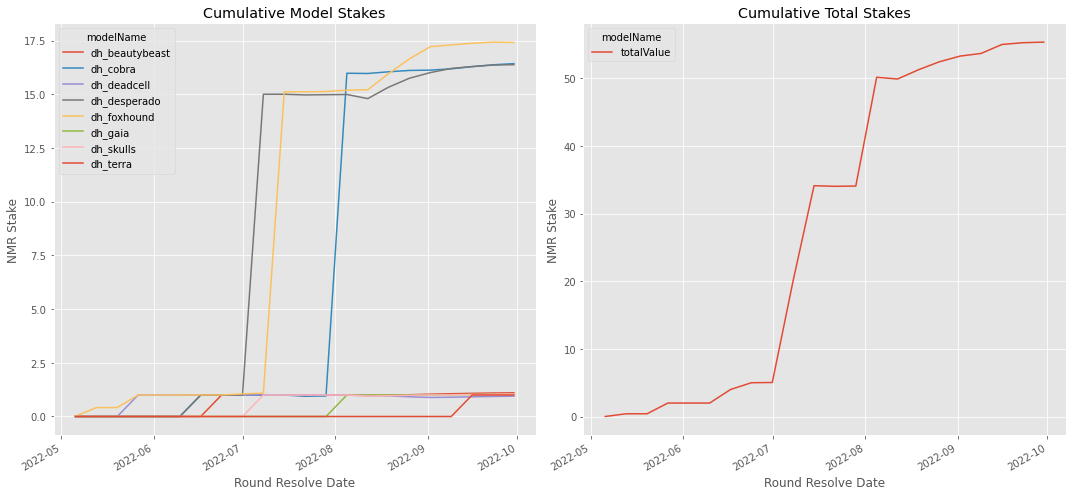

In [81]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2)
staking.loc[AFTER_DATE:][[col for col in staking.columns if col.startswith("dh_")]].plot(ax=axes[0])
staking.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1])
axes[0].set_title("Cumulative Model Stakes")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Stake")
axes[1].set_title("Cumulative Total Stakes")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Stake")
plt.tight_layout()
plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
plt.show()

---
# Total Return

In [82]:
# get return
total_return = pd.concat([payout.sum(), staking.tail(1).T], axis=1)
total_return.columns = ["payout", "staking"]
total_return["return"] = total_return["payout"] / total_return["staking"]

total_return

,payout,staking,return
modelName,,,
dh_beautybeast,0.175054,1.102352,0.158800
dh_cobra,1.170281,16.425419,0.071248
dh_deadcell,0.021403,0.945776,0.022630
dh_desperado,2.167048,16.375313,0.132336
dh_foxhound,3.222871,17.409936,0.185117
dh_gaia,0.048334,1.029717,0.046940
dh_skulls,0.124935,1.042172,0.119879
dh_terra,0.086378,1.000000,0.086378
totalValue,7.016304,55.330686,0.126807


In [83]:
# daily staking 
round_return = pd.concat([payout["totalValue"], staking["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

round_return

,payout,staking,return
roundResolveTime,,,
2022-05-05 20:00:00+00:00,0.000000,0.014453,0.000000
2022-05-12 20:00:00+00:00,0.002033,0.414453,0.004906
2022-05-19 20:00:00+00:00,0.000667,0.414453,0.001609
2022-05-26 20:00:00+00:00,0.035571,2.000003,0.017785
2022-06-02 20:00:00+00:00,0.068884,2.000003,0.034442
2022-06-09 20:00:00+00:00,0.006714,2.000003,0.003357
2022-06-16 20:00:00+00:00,-0.089689,4.002037,-0.022411
2022-06-23 20:00:00+00:00,0.040450,5.002704,0.008086
2022-06-30 20:00:00+00:00,0.074851,5.038274,0.014857


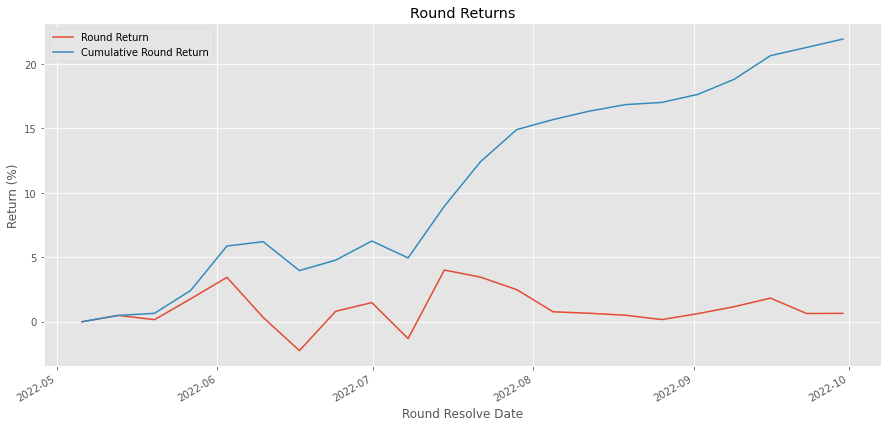

In [84]:
# plot round return
plt.figure()
(round_return["return"] * 100).plot()
(round_return["return"] * 100).cumsum().plot()
plt.legend(["Round Return", "Cumulative Round Return"])
plt.title("Round Returns")
plt.xlabel("Round Resolve Date")
plt.ylabel("Return (%)")
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()

---
# Sharpe Performance

In [85]:
# sharpe calc
def get_sharpe(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["modelName"])[metric].size(),
        df_clean.groupby(["modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = sharpe_df.loc[sharpe_df["n"]>=10].sort_values("sharpe")
    return sharpe_df

In [86]:
# rank by sharpe
corr_sharpe_df = get_sharpe(df=perf, metric='correlation')
tc_sharpe_df = get_sharpe(df=perf, metric='tc')

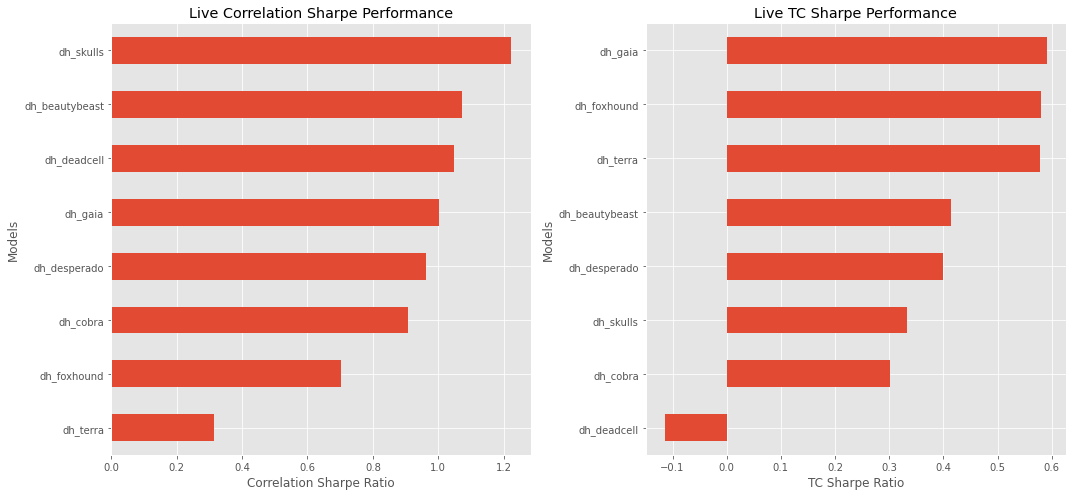

In [87]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpe_df["sharpe"].plot.barh(ax=axes[0])
tc_sharpe_df["sharpe"].plot.barh(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance")
axes[0].set_xlabel("Correlation Sharpe Ratio")
axes[0].set_ylabel("Models")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("TC Sharpe Ratio")
axes[1].set_ylabel("Models")
plt.savefig('plots/SharpeRatioPlots.png', facecolor='w')
plt.tight_layout()
plt.show();

In [88]:
# sharpe calc (ts)
def get_sharpe_ts(df, metric):
    def sharpe(x):
        return x.mean() / x.std()
    df_clean = df.query(f"roundNumber >= {AFTER_ERA}").copy()
    sharpe_df = pd.concat([
        df_clean.groupby(["roundNumber", "modelName"])[metric].size(),
        df_clean.groupby(["roundNumber", "modelName"])[metric].apply(lambda x: sharpe(x))], 
        axis=1)
    sharpe_df.columns = ["n", "sharpe"]
    sharpe_df = (
        sharpe_df
        .loc[sharpe_df["n"]>=10]
        .reset_index()
        .sort_values(["modelName", "roundNumber"])
        .drop("n", axis=1)
        .pivot(index='roundNumber', columns='modelName', values='sharpe'))
    return sharpe_df

In [89]:
# rank by sharpe ts
corr_sharpets_df = get_sharpe_ts(df=perf, metric='correlation')
tc_sharpets_df = get_sharpe_ts(df=perf, metric='tc')

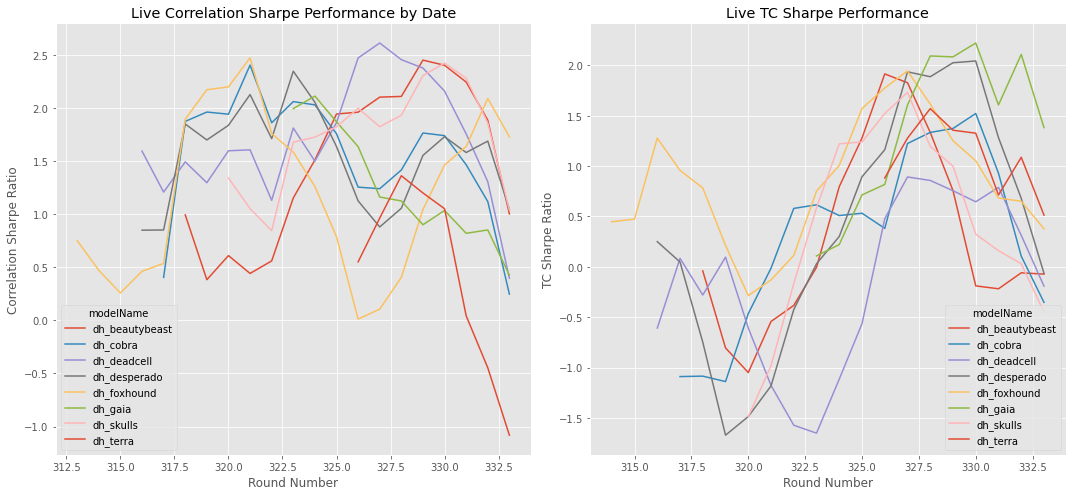

In [90]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpets_df.rolling(4).mean().plot(ax=axes[0])
tc_sharpets_df.rolling(4).mean().plot(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance by Date")
axes[0].set_xlabel("Round Number")
axes[0].set_ylabel("Correlation Sharpe Ratio")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("Round Number")
axes[1].set_ylabel("TC Sharpe Ratio")
plt.savefig('plots/SharpeRatioTSPlots.png', facecolor='w')
plt.tight_layout()
plt.show();